<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/Hello_cu_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello cu_cat: Easy automatic feature engineering for messy dataframes on GPUs!
Daniel, Tanmoy, Alex, Leo


[  [LOOM](https://www.loom.com/share/10231b9dd07f4e979942fd10140e2dd0)  ] – press play and dive into analysis!

The latest [PyGraphistry[AI]](https://github.com/graphistry/pygraphistry/) release GPU accelerates its automatic feature encoding pipeline, by introducing a new member to the open source GPU dataframe ecosystem: cu_cat.

Cu_cat is our GPU-accelerated open source fork of the popular CPU Python  library dirty_cat.   Like dirty_cat, cu_cat makes it easy to convert messy dataframes filled with numbers, strings, and timestamps into numeric feature columns optimized for AI models. It adds interoperability for GPU dataframes and replaces key kernels and algorithms with faster and more scalable GPU variants. **Even on low-end GPUs, we are now able to tackle much larger datasets in the same amount of time – or for the first time! – with end-to-end pipelines. We typically save time with 3-5X speedups and will even see 10X+.**

In [ ]:
# !pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11==22.10.0 cudf-cu11==22.10.0 cugraph-cu11==22.10.0 pylibraft_cu11==22.10.0 raft_dask_cu11==22.10.0 dask_cudf_cu11==22.10.0 pylibcugraph_cu11==22.10.0 pylibraft_cu11==22.10.0
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11


In [2]:
import cuml,cudf
cuml.__version__

'23.04.01'

In [ ]:
!pip install -U --force git+https://github.com/graphistry/pygraphistry.git@feat/gpu-featurization
!pip install -U git+https://github.com/graphistry/cu-cat.git@DT5

In [4]:
!git+http://github.com/graphistry/cu-cat/tarball/datetimeegg=package-0.03.0

/bin/bash: git+http://github.com/graphistry/cu-cat/tarball/datetimeegg=package-0.03.0: No such file or directory


In [5]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [6]:
!echo "0.01.0" > VERSION.txt
!cp VERSION.txt /root/.local/lib/python3.9/site-packages/cu_cat/
# !cp VERSION.txt /usr/local/lib/python3.9/dist-packages/cu_cat/

cp: cannot create regular file '/root/.local/lib/python3.9/site-packages/cu_cat/': No such file or directory


In [7]:
# from importlib import reload
# reload(cu_cat)
import cu_cat
print(cu_cat.__file__)

/usr/local/lib/python3.10/dist-packages/cu_cat/__init__.py


In [8]:
import os
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pstats import Stats
import cudf
from time import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 200)

In [9]:
import graphistry

graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__


'0.28.7+463.gfb96400'

In [ ]:
!pip install dirty_cat

In [64]:
# !nvidia-smi --query-gpu=gpu_name --format=csv
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
# !nvidia-smi -L
# import sys
# import os

# gpu=(sys.argv[1])
# gpu
import os

Tesla T4


In [98]:
!nvidia-smi --query-gpu=gpu_name --format=csv
!pip install nvsmi
import nvsmi
gpu=str(nvsmi.get_gpu_processes()).split('|')[3].split(':')[1]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
X=1
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
from time import time


In [ ]:
# import cupy as cp
# del g
# cp._default_memory_pool.free_all_blocks()
# winlogs.drop(columns='Time')

## look at dataset (select non-sparse columns)

In [138]:
winlogsA=pd.read_parquet('part.88.parquet')
winlogsA

,UserName,EventID,LogHost,LogonID,DomainName,ParentProcessName,ParentProcessID,ProcessName,Time,ProcessID,...,Source,AuthenticationPackage,LogonType,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,FailureReason,Status,ServiceName
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,Comp079636$,4688,Comp079636,0x3e7,Domain001,svchost,0x434,taskeng.exe,7603200,0x283c,...,None,None,NaN,None,None,None,None,None,None,None
1,Comp798894$,4688,Comp798894,0x3e7,Domain001,csrss,0x1f8,conhost.exe,7603200,0x19e0,...,None,None,NaN,None,None,None,None,None,None,None
2,Comp798894$,4688,Comp798894,0x3e7,Domain001,services,0x2c0,Proc857443.exe,7603200,0x1d08,...,None,None,NaN,None,None,None,None,None,None,None
3,Comp918018$,4688,Comp918018,0x3e7,Domain001,svchost,0x360,dllhost.exe,7603200,0x12b0,...,None,None,NaN,None,None,None,None,None,None,None
4,Comp459973$,4688,Comp459973,0x3e7,Domain001,svchost,0x458,taskeng.exe,7603200,0x5090,...,None,None,NaN,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,Scanner,4672,Comp803010,0x64b0826,Domain001,None,None,None,7610591,None,...,None,None,NaN,None,None,None,None,None,None,None
4999996,Scanner,4624,Comp803010,0x64b0826,Domain001,None,None,None,7610591,None,...,Comp073202,NTLM,3.0,None,None,None,None,None,None,None
4999997,Scanner,4634,Comp803010,0x64b0826,Domain001,None,None,None,7610591,None,...,None,None,3.0,None,None,None,None,None,None,None


## run loops per size and feature_engine, ie cu_cat and dirty_cat, remembering to set memoize=False

In [139]:
# bench=pd.DataFrame(columns=['dataset','row','col','cc_time','dc_time'])
!wget -nc https://www.dropbox.com/s/31dx1g6g59exoc3/part.88.parquet

bench=pd.DataFrame(columns=['dataset','row','col','cc_time','dc_time'])

winlogsA=pd.read_parquet('part.88.parquet')
n=[5000,10000,50000,100000]#,500000,1000000]

for ii,i in enumerate(n):

      winlogs=winlogsA.sample(i,replace=False)#.iloc[:,:10]
      # winlogs.drop(columns='Time',inplace=True)
      # winlogs=winlogs[['EventID','LogHost','UserName','Time']] #,'DomainName']]

      g = graphistry.nodes(cudf.from_pandas(winlogs))
      t=time()
      g.umap(engine='cuda',memoize=False)
      t1=time()-t

      g = graphistry.nodes(winlogs)
      t=time()
      g.featurize(feature_engine='dirty_cat',engine='cuml',memoize=False)
      t2=time()-t

      bench.loc[1+bench.shape[0]]=['winlogs',winlogs.shape[0],winlogs.shape[1],t1,t2]
      bench.to_csv('winlogs_'+str(gpu.strip())+'_bench_'+timestr+'.txt',sep='\t',mode='a')


File ‘part.88.parquet’ already there; not retrieving.



Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat
Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat
Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat
Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


Featurizing nodes with feature_engine=cu_cat
Using GPU: cu_cat
Featurizing nodes with feature_engine=dirty_cat
Using GPU: dirty_cat


In [137]:
i

100000

#plot results and export

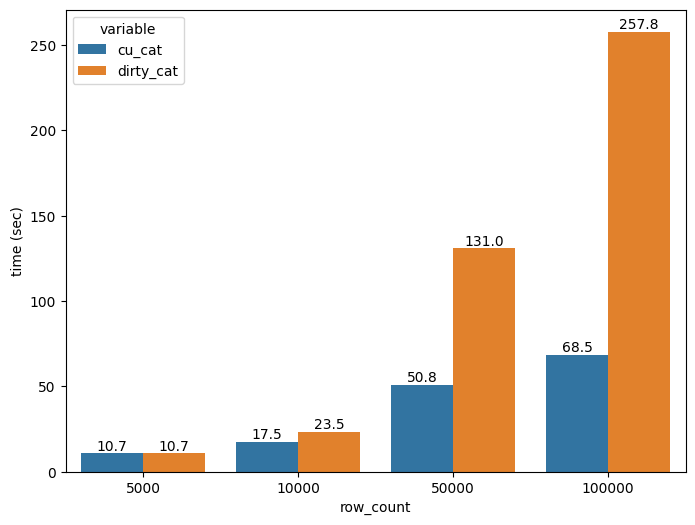

In [140]:
bench=bench.rename(columns={'cc_time':'cu_cat','dc_time':'dirty_cat'})
dd=bench.melt(id_vars=['dataset','row','col'])
dd=dd[dd.dataset.str.contains('winlogs')]

dd.value=dd.value.astype('float')
dd.row=dd.row.astype('int')
dd=dd.rename(columns={'row':'row_count','value':'time (sec)'})
dd

dd=dd[dd.row_count<1000000]
dd=dd[dd.row_count>2000]


plt.figure(figsize=(8, 6))

import seaborn as sns

capsize = .1

ax = sns.barplot(data=dd,  x="row_count", y="time (sec)", hue="variable", capsize=capsize)

patches = ax.patches
lines_per_err = 1 if capsize is None else 3
ax.bar_label(ax.containers[0], fmt='%.1f')
ax.bar_label(ax.containers[1], fmt='%.1f')

for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i // lines_per_err]#.get_facecolor()
    line.set_color('black')

fig = ax.get_figure()
fig.savefig('winlogs_'+str(gpu.strip())+'_bench_'+timestr+'.png') 


In [141]:
from google.colab import files
files.download('winlogs_'+str(gpu.strip())+'_bench_'+timestr+'.txt')
files.download('winlogs_'+str(gpu.strip())+'_bench_'+timestr+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [142]:
bench

,dataset,row,col,cu_cat,dirty_cat
1,winlogs,5000,4,10.711245,10.747021
2,winlogs,10000,4,17.536561,23.531860
3,winlogs,50000,4,50.776295,130.950002
4,winlogs,100000,4,68.502170,257.844444
